In [32]:
from pathlib import Path
import sys

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))


In [33]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
#from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob
import torch.nn.functional as F
import warnings
from sklearn.metrics import mean_squared_error
#import mae function
from sklearn.metrics import mean_absolute_error
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [34]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

In [35]:
# dataread and features
from data.preprocess import read_txn_data , preprocess_txn_data, compute_lob_features, \
    create_lob_dataset, merge_txn_and_lob

# desesonalisation
from models.deseasonalization import deses

# Parameters

In [36]:
def set_neurips_style():
    plt.rcParams.update({
        "font.family":       "sans-serif",
        "font.size":         12,
        "axes.spines.top":   False,
        "axes.spines.right": False,
        "axes.grid":         True,
        "grid.linestyle":    ":",
        "grid.alpha":        0.5,
        "figure.dpi":        120,
        "legend.frameon":    False,
    })

set_neurips_style()

In [37]:
config = {
    "data_split": {
        "train_size": 0.7,
        "validation_size": 0.1,
        "test_size": 0.2
    },
    "model_params": {
        "learning_rate": 0.001,
        "batch_size": 10000,
        "epochs": 10
        ,
    }
}

# Check GPU 

In [38]:
import torch

if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
    print(f"Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Reserved : {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")
    print(f"Max Alloc: {torch.cuda.max_memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Max Rsvd : {torch.cuda.max_memory_reserved(0) / 1024**2:.2f} MB")
else:
    print("CUDA not available.")


Device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Allocated: 16.36 MB
Reserved : 7366.00 MB
Max Alloc: 6129.72 MB
Max Rsvd : 7366.00 MB


In [39]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1 Min 

#### 1.1 Load Data

In [40]:
freq='1min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df_raw = merge_txn_and_lob(trx_df, lob_df)
df_des, _ = deses(df_raw, train_size=config["data_split"]["train_size"])

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


#### 1.2 TME 

\begin{array}{c|c|c|c|c}
\hline \text { BITSTAMP MARKET } & \text { RMSE } \downarrow & \text { MAE } \downarrow & \text { NNLL } \downarrow & \text { IW } \downarrow \\
\hline \text { ARMA(3,3)-GARCH(1,1) } & 14.587 & 7.688 & \mathbf{1 . 7 1 9} & 97.618 \\
\text { ARMAX(3,3)-GARCH(1,1) } & 14.292 & 7.487 & 1.719 & 93.943 \\
\text { GBM } & 11.740 & \mathbf{3 . 5 1 5} & \text { NA } & \text { NA } \\
\text { TME } & \mathbf{1 1 . 3 7 8} & 4.299 & 1.720 & \mathbf{1 0 . 2 9 5} \\
\hline
\end{array}

ep01  train 5.8057  val 5.3496
ep02  train 3.5107  val 3.5485
ep03  train 2.7077  val 2.8725
ep04  train 2.4667  val 2.6962
ep05  train 2.4067  val 2.6332
ep06  train 2.3902  val 2.5923
ep07  train 2.3812  val 2.5700
ep08  train 2.3764  val 2.5604
ep09  train 2.3729  val 2.5550
ep10  train 2.3687  val 2.5498
Metric     |      Value
-----------------------
RMSE         |      11.91
MAE           |       4.20
R²             |    -0.0206
MAPE (%)  |     157.47
Coverage  |       99.9 %
IW             | 47741573.02
NNLL         |     2.8841


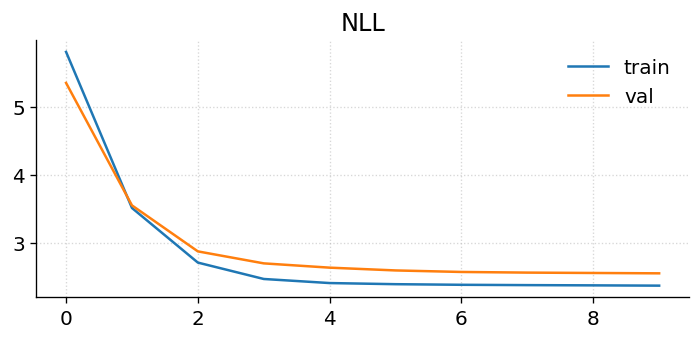

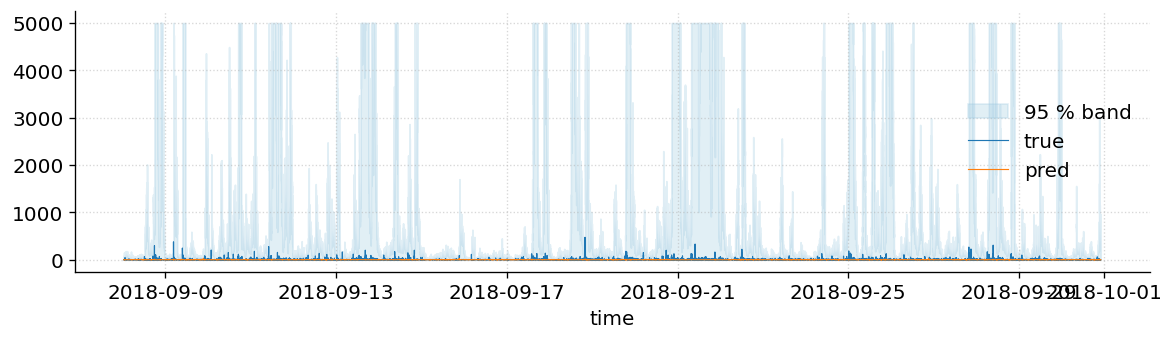

In [41]:
from models.tme import TME
tme = TME(df_des, config)   # config is the dict you already have
tme.train()                 # prints epoch-wise NLL
y_true,y_pred=tme.evaluate()              # metrics + two plots

# 5 Min

#### 1.1 Load Data

In [42]:
freq='5min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df_raw = merge_txn_and_lob(trx_df, lob_df)
df_des, _ = deses(df_raw, train_size=config["data_split"]["train_size"])

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


#### 1.2 TME 

\begin{array}{|c|c|c|c|c|}
\hline \text { BITSTAMP MARKET } & \text { RMSE } \downarrow & \text { MAE } \downarrow & \text { NNLL } \downarrow & \text { IW } \downarrow \\
\hline \text { ARMA(5,4)-GARCH(1,1) } & 38.300 & 17.606 & \mathbf{3 . 7 3 2} & 34.797 \\
\text { ARMAX(5,4)-GARCH(1,1) } & 40.273 & 18.887 & 3.766 & 38.250 \\
\text { GBM } & 39.196 & \mathbf{1 4 . 7 1 4} & \text { NA } & \text { NA } \\
\text { TME } & \mathbf{3 8 . 2 2 3} & 17.287 & 3.765 & \mathbf{2 9 . 1 4 8} \\
\hline
\end{array}

ep01  train 2.4911  val 2.8837
ep02  train 2.1698  val 2.4987
ep03  train 2.0345  val 2.2773
ep04  train 1.9430  val 2.1767
ep05  train 1.9181  val 2.1409
ep06  train 1.9435  val 2.1243
ep07  train 1.9533  val 2.1109
ep08  train 1.9577  val 2.0986
ep09  train 1.9516  val 2.0920
ep10  train 1.9308  val 2.0975
Metric     |      Value
-----------------------
RMSE         |      35.96
MAE           |      17.98
R²             |    -0.0370
MAPE (%)  |     436.61
Coverage  |       99.6 %
IW             |     554.42
NNLL         |     2.4831


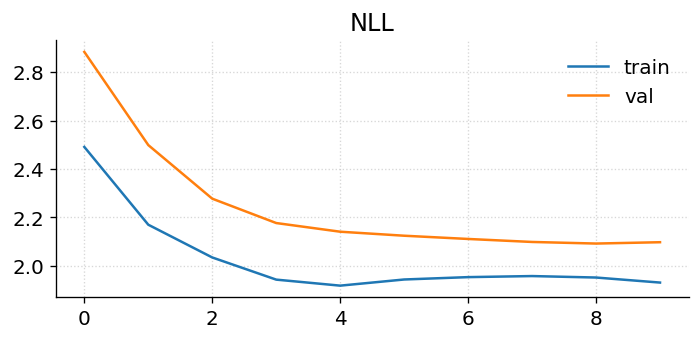

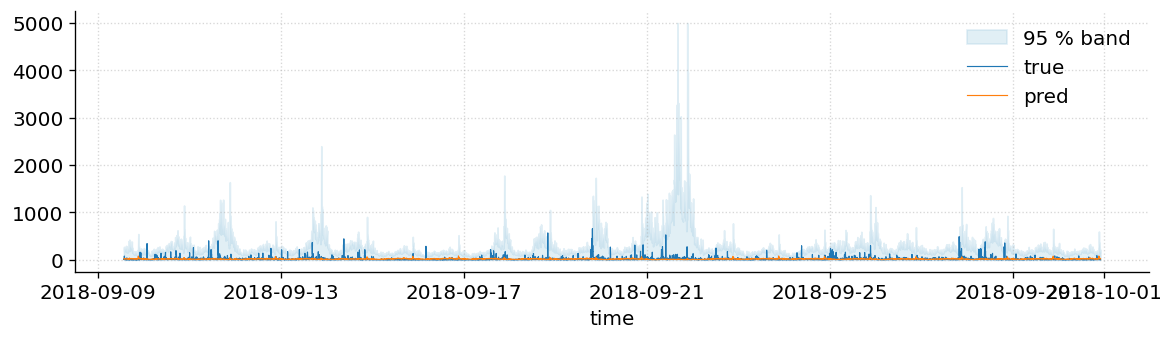

In [43]:
from models.tme import TME
tme = TME(df_des, config)   # config is the dict you already have
tme.train()                 # prints epoch-wise NLL
y_true,y_pred=tme.evaluate()              # metrics + two plots

# 10 Min

#### 1.1 Load Data

In [46]:
freq='10min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df_raw = merge_txn_and_lob(trx_df, lob_df)
df_des, _ = deses(df_raw, train_size=config["data_split"]["train_size"])

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


#### 1.2 TME 

\begin{array}{|c|c|c|c|c|}
\hline \text { BITSTAMP MARKET } & \text { RMSE } \downarrow & \text { MAE } \downarrow & \text { NNLL } \downarrow & \text { IW } \downarrow \\
\hline \text { ARMA(3,2)-GARCH(1,1) } & 66.486 & 31.942 & \mathbf{4 . 4 5 2} & 51.228 \\
\text { ARMAX(3,2)-GARCH(1,1) } & 68.067 & 32.795 & 4.457 & 52.780 \\
\text { GBM } & 67.128 & \mathbf{2 7 . 7 1 9} & \text { NA } & \text { NA } \\
\text { TME } & \mathbf{6 6 . 2 3 4} & 31.460 & 4.507 & \mathbf{4 9 . 9 7 2} \\
\hline
\end{array}

ep01  train 6.4960  val 1.9699
ep02  train 1.7564  val 1.8659
ep03  train 1.7056  val 1.8198
ep04  train 1.6964  val 1.7902
ep05  train 1.7357  val 1.7681
ep06  train 1.7017  val 1.7453
ep07  train 1.6899  val 1.7266
ep08  train 1.6907  val 1.7239
ep09  train 1.6760  val 1.7473
ep10  train 1.6845  val 1.7916
Metric     |      Value
-----------------------
RMSE         |      59.07
MAE           |      35.18
R²             |    -0.0329
MAPE (%)  |     458.59
Coverage  |       98.1 %
IW             |     362.54
NNLL         |     2.3206


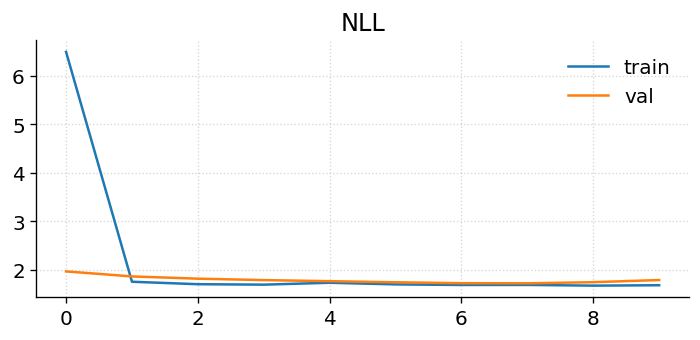

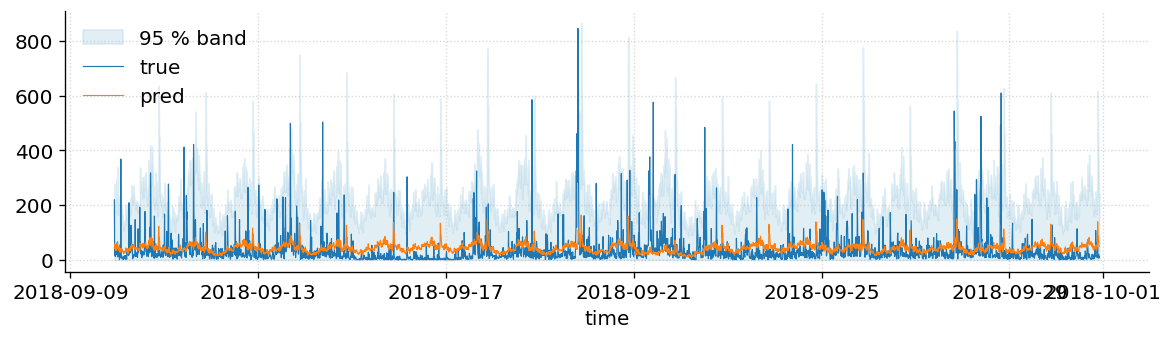

In [47]:
from models.tme import TME
tme = TME(df_des, config)   # config is the dict you already have
tme.train()                 # prints epoch-wise NLL
y_true,y_pred=tme.evaluate()              # metrics + two plots